# Advanced Lane Lines Detection

### Contents
1. **Camera calibration**  
    1.1. Distortion correction  
2. **Perspective transform**  
    2.1 Example
3. **The Sobel operator**  
    3.1. Gradient magnitude  
    3.2. Gradient direction  
    3.3. Combining absolute value, magnitude and direction together  
4. **Color spaces**  
    4.1. Combining color and gradient thresholding  
5. **Histogram peaks and sliding window**  
    5.1. Sliding window

## Preface
In a real-world scenario, we must take into consideration the fact that disturbing elements may be present in the image. For this reason, in this notebook we will deal with:
- camera calibration and distortion correction, in order to fix distortion caused by the lens,
- perspective transform, in order to change perspective and ease the task of detecting lines,
- exploring different color spaces than RGB, such as HSV or HSL, in order to highlight lines in different lighting conditions,

We willa also deal with curved lane lines. Knowing the curvature of the lane lines is fundamental for a self-driving car, in order to know the correct steering angle to turn. 

To determine the curvature we:
1. Detect the lane lines using masking and thresholding techniques.
2. Perform a perspective transform to get a bird's-eye view of the lane (view from above)
3. Solve a regression problem fitting a polynomial to the lane lines.
4. Extract the curvature of the lines from the fitted polinomial

# Camera calibration

When a camera captures an image of the 3D world, it transfors it into a 2D image through multiple lenses. Lenses can introduce **distortion**, since light rays often bend too much or too little at the edges of the curved lens, causing  images to result distorted (curved) at their edges. This type of distortion is called ***radial distortion***. A different type of distortion is the so-called ***tangential distortion***, which can occur when a camera's lens is not perfectly parallel to the imaging plane. Tangential distortion causes the image to look tilted, vertically or horizontally.

Consequently, distortion can change both the shape and the size of an object.

## Distortion correction

A radially distorted image can be corrected by a spatial transformation, according to some parameters $k_1,k_2$ and $k_3$. In particular, we can calculate the distance $r$ between a point $(x_{corrected},y_{corrected})$ in the undistorted image and the center of the image distortion $(x_c,y_c)$, often coinciding with the image center.

$$x_{distorted} = x_{ideal}\left(1+k_1r^2 + k_2r^4 + k_3r^6\right)$$
$$y_{distorted} = y_{ideal}\left(1+k_1r^2 + k_2r^4 + k_3r^6\right)$$

In the case of tangential distortion, then the parameters become $p_1$ and $p_2$, and the correction formula becomes:

$$x_{corrected} = x + \left[2p_1xy + p_2 (r^2 + 2x^2) \right]$$
$$y_{corrected} = y + \left[p_1(r^2 + 2y^2) + 2p_2xy \right]$$

### Calibrating the parameters

Parameters used in distortion correction can be calibrated, for example, by taking pictures of known objects, such as a chessboard which contains a regular and high-contrast content, therefore by computing a map from the distorted image to the correct one.

OpenCV provides us two useful functions that can help us with this task: `findChessboardCorners()` and `drawChessboardCorners()`. Furthermore, once we have collected the image points and we know the true coordinates of the chessboard's points, we use them in order to calibrate the camera through the function `calibrateCamera()`. This function will return the *distortion coefficients* `dist` and the *camera matrix* `mtx` that we'll need to transform 3D objects points to 2D image points. It also returns the position of the camera in the world, with values for rotation and translation vectors. Finally, by using `undistort()`, we generate the undistorted matrix (destination matrix). 

In the following code snippet, we will use those two functions in order to 
1. Detect the corners in several images of a chessboard, taken from different angles. Images belong to Udacity.
2. Calibrate the camera.
3. Undistort the image.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

In [2]:
img_path = 'test_images/calibration/'
calib_img_path = img_path + 'distortion/'
# List of calibration images
images = glob.glob(calib_img_path+'GO*.jpg')

visualize = False

nx = 8 # points along each row
ny = 6 # points along each col
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points like (0,0,0), (1,0,0), (2,0,0), ..., (7,5,0)
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates

for fname in images:
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        if visualize == True:
            # draw and display corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)
            
cv2.destroyAllWindows()

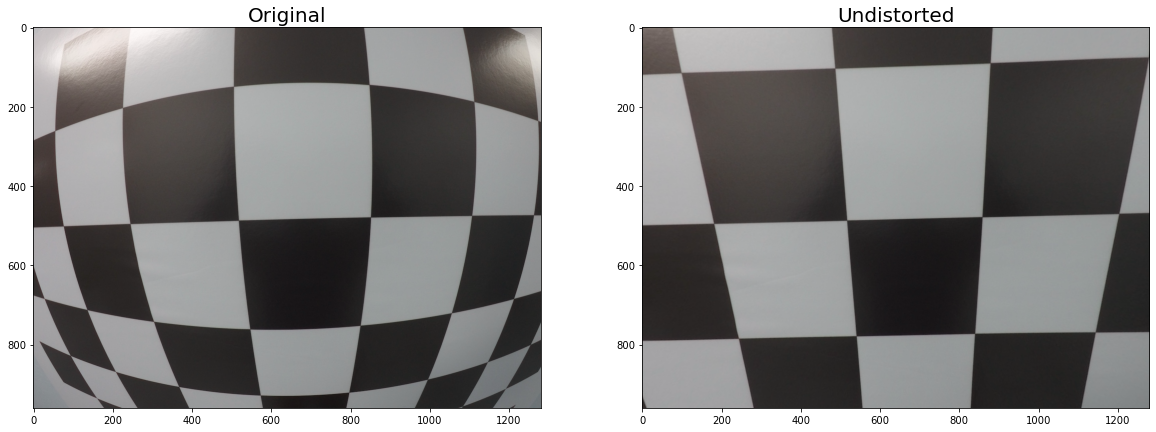

In [3]:
save_img = False
save_params = False

# Test undistortion on an image
img = cv2.imread(calib_img_path+'test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Given objpoints and imgpoints, retrieve calibration parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

udst = cv2.undistort(img, mtx, dist, None, mtx)
if save_img == True:
    cv2.imwrite(calib_img_path + 'test_undist.jpg', udst) # save undistorted img

# Save camera calibration parameters
if save_params == True:
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open(calib_img_path + 'wide_dist_pickle.p', 'wb'))
    
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(udst)
ax2.set_title('Undistorted', fontsize=20)
plt.show()

Once the camera is calibrated, we can use the camera matrix `mat` and distortion coefficients `dist` we found to undistort also the test images (oviously taken with the same camera). 

---

# Perspective transform

Perspectivity is the formation of an image in a picture plane of a scene viewed from a fixed point. Perspective is the phenomenon where an object appears smaller the farther away it is from the viewpoint, and parallel lines appear to converge to a point called *point at infinity*, or *ideal point*. The greater the magnitude of an object's *z*-coordinate, or distance from the camera, the smaller it will appear in the 2D image. A perspective transform maps the points in an image to different ones with a new perspective. It essentially transform the apparent *z*-coordinate of object points which in turn changes that object 2D image representation. In other words it "pushes away" points that are closer to the viewpoint, and "pushes towards" points that are far from the viewpoint.

We are interested in transforming a 2D image in a bird's-eye view that will facilitate the task of interpolating the lines and determining their curvature. The process of applying a perspective transform is similar to what we've done to fix image distortion, but in this case, instead of mapping object points to image points, we will map the points in a given image to different, desired, image points with a new perspective.


### Example: perspective transform

In the following exercise, we will apply a perspective transformation on an image of a stop sign, in order to view it from the front, rather than from a certain angle. In order to do it, we first need to:
1. Identify 4 points that defines a rectangle in the original image (we will choose 4 points on the surface of the stop sign, which has a hexagonal shape). Those 4 points are enough to define a linear transformation from one perspective to another. 
2. Select where we want those 4 points to appear in the transformed image, also called *warped image*. 
3. Using [`getPerspectiveTransform()`](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae) from OpenCV, we compute the transformation matrix $M$.
4. Transform the original image in the warped image using [`warpPerspective()`](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87), which will compute

$$\texttt{dst} (x,y) = \texttt{src} \left ( \frac{M_{11} x + M_{12} y + M_{13}}{M_{31} x + M_{32} y + M_{33}} , \frac{M_{21} x + M_{22} y + M_{23}}{M_{31} x + M_{32} y + M_{33}} \right ).$$

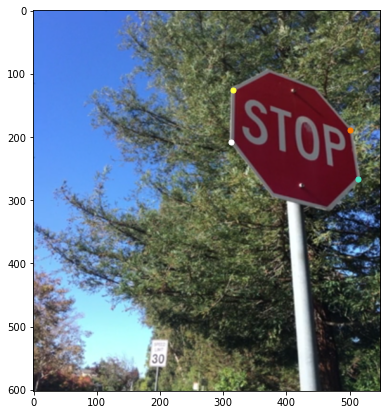

In [4]:
# uncomment next line to enter interactive mode and retrieve the coordinates of the desired points
#%matplotlib qt

persp_img_path = img_path + 'perspective/'
img = mpimg.imread(persp_img_path + 'stopsign.jpg')

h, w = img.shape[:2]

plt.figure(figsize=(7,7))
plt.imshow(img)
# show corners of rectangular shape
src = np.array([(316, 126), (500, 189), (312, 208), (513, 266)], np.float32)
colors = ['#ffff3f', '#ff7d00', '#ffffff', '#48E5C2']
for point, c in zip(src, colors):
    plt.plot(*point, '.', color=c, markersize=10)
plt.show()

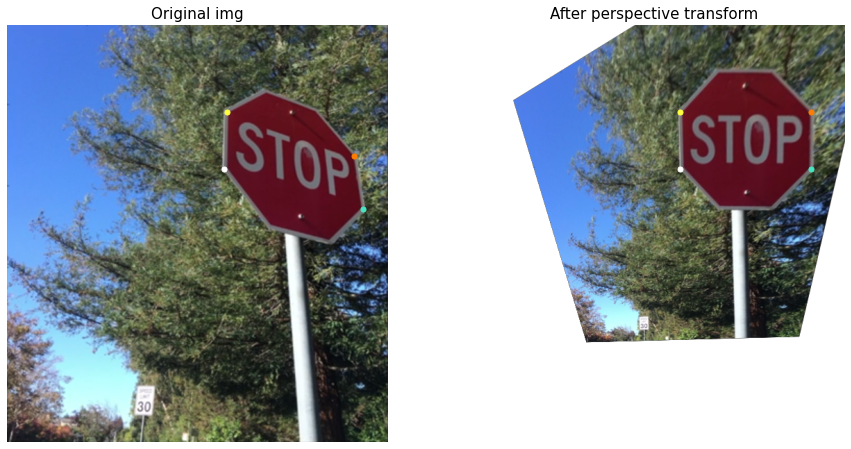

In [5]:
dst = np.array([(312, 126), (500, 126), (312, 208), (500, 208)], np.float32)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

# compare images
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
fig.set_facecolor('white')
ax1.set_title('Original img', fontsize=15)
ax1.imshow(img) #add cmap='gray'
for point, c in zip(src, colors):
    ax1.plot(*point, '.', color=c, markersize=10)
ax1.set_axis_off()

ax2.set_title('After perspective transform', fontsize=15)
ax2.imshow(warped) 
for point, c in zip(dst, colors):
    ax2.plot(*point, '.', color=c, markersize=10)
ax2.set_axis_off()

---
# The Sobel operator

In the first part of this project, we used the Canny edge detector to find pixels that are likely to be part of a line, but since Canny is able to find all possible lines in an image, we ended up with a lot of additional lines to the ones we were interested in, leading us to discard lines in the background and outside of the road. We can benefit from the fact that lane lines tend to be vertical. With Canny we were taking a derivative with respect to both $x$ and $y$.

At the heart of the Canny edge detection algorithm there is the Sobel operator. Examples of Sobel operators with a kernel size of $3\times 3$ are:

$$S_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1\end{bmatrix}, \qquad 
S_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1\end{bmatrix}$$

Larger kernels of odd size correspond to smoother gradients, less sensitive to noisy intensity fluctuations, since we are taking the gradient over a larger portion of the image.

In the following code snippet, we are going to apply the Sobel operator on an image, and compute both the horizontal and the vertical derivative. After doing so, it can be useful to convert the filtered image to 8-bit (range from 0 to 255), because, since we are going to apply a threshold (in order to keep just values that are within a certain range), we want it to behave the same way with input images of different scales (jpg, png, ...).

In [6]:
def abs_sobel_thresh(img, kernel_size=3, thresh=(0,255), visualize=False):
    # convert to grayscale (if img has been read through cv2.imread, then we have to use COLOR_BGR2GRAY instead)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # compute derivative in x direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)

    # compute absolute value
    abs_sobelx = np.absolute(sobelx)

    # convert to 8-bit
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # do the same for y direction
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))

    # perform thresholding
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh[0]) & (scaled_sobelx <= thresh[1])] = 1
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= thresh[0]) & (scaled_sobely <= thresh[1])] = 1

    # visualize
    if visualize == True:
        fs = 20 # fontsize
        fig, axs = plt.subplots(3, 2, figsize=(18,15))
        fig.tight_layout()
        axs[0,0].imshow(img)
        axs[0,0].set_title('Original image', fontsize=fs)
        axs[1,0].imshow(scaled_sobelx, cmap='gray')
        axs[1,0].set_title('Sobel x (abs)', fontsize=fs)
        axs[1,1].imshow(scaled_sobely, cmap='gray')
        axs[1,1].set_title('Sobel y (abs)', fontsize=fs)
        axs[2,0].imshow(sxbinary, cmap='gray')
        axs[2,0].set_title('Thresholded x', fontsize=fs)
        axs[2,1].imshow(sybinary, cmap='gray')
        axs[2,1].set_title('Thresholded y', fontsize=fs)
        for axis in axs:
            axis[0].set_axis_off()
            axis[1].set_axis_off()
        plt.show()
    
    return (sxbinary, sybinary)

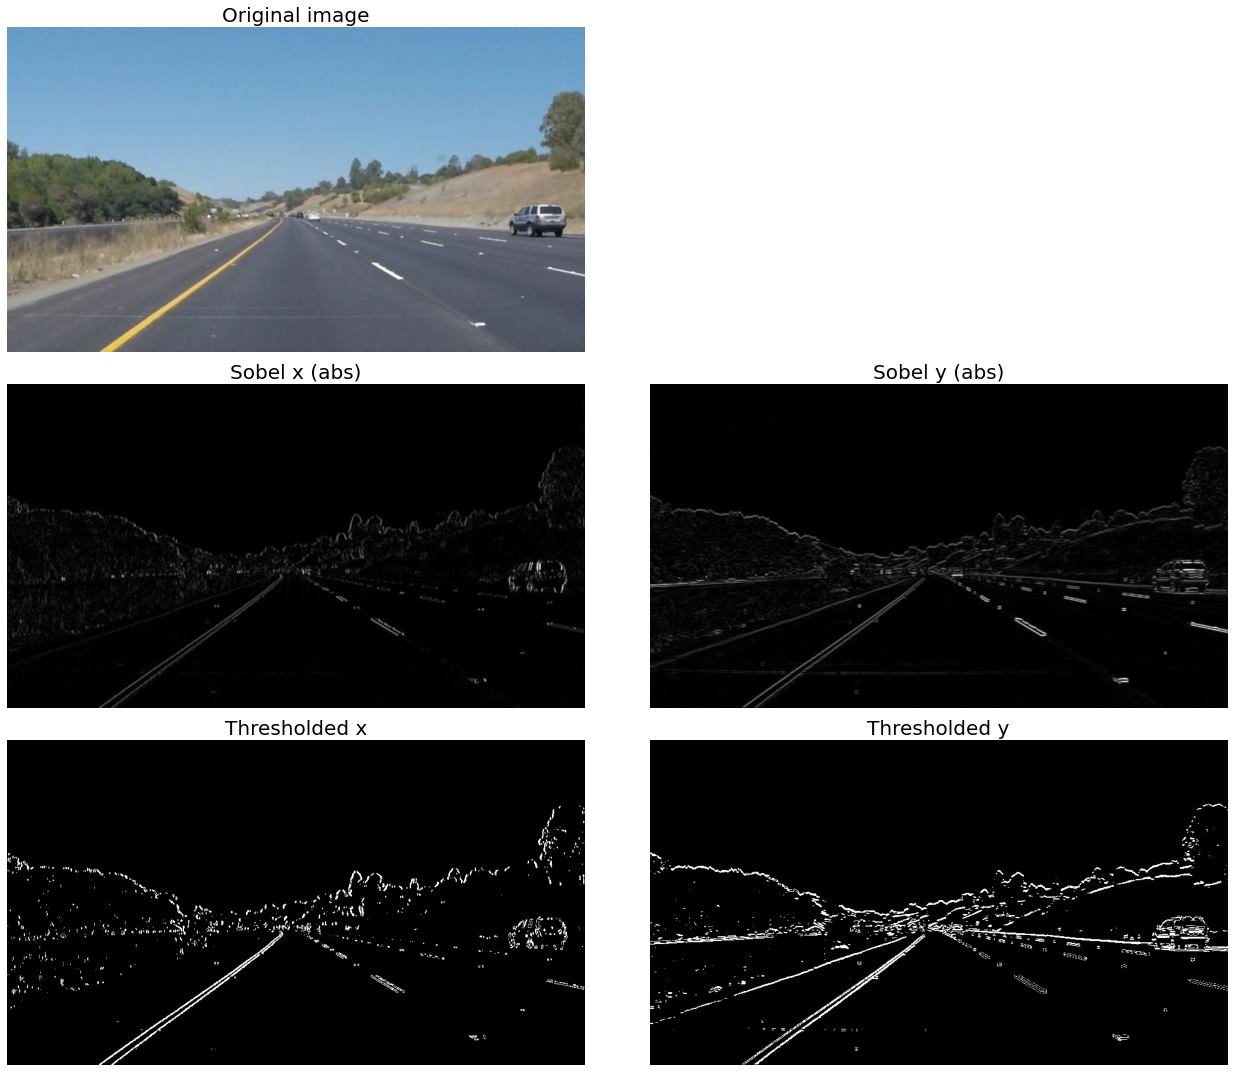

In [7]:
# test abs_sobel_thresh
img = mpimg.imread('test_images/solidYellowCurve.jpg')
sxbinary, sybinary = abs_sobel_thresh(img, kernel_size=3, thresh=(35,100), visualize=True)

## Gradient magnitude

Overall, we can see that the x gradient does a better job at picking up lane lines. Now we will apply thresholding on the overall magnitude of the gradient:

$$sobel_{abs} = \sqrt{(sobel_x)^2 + (sobel_y)^2}$$

In [8]:
def mag_thresh(img, kernel_size=3, thresh=(0,255)):
    """
    Compute the gradients through the Sobel operator, 
    then compute gradient's magnitude and finally perform thresholding 
    """
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    # compute gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    
    # perform thresholding
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary_output

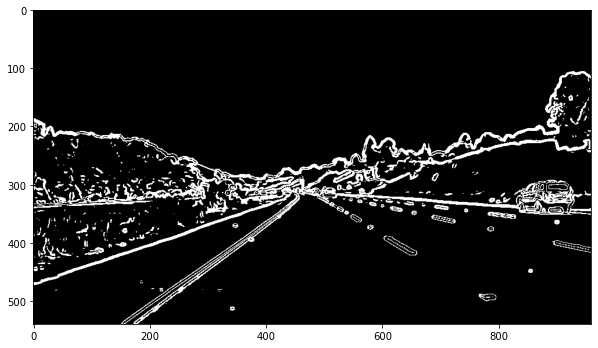

In [9]:
# test mag_thresh with larger kernels
plt.figure(figsize=(10,10))
plt.imshow(mag_thresh(img, kernel_size=9, thresh=(30, 100)), cmap='gray')
plt.show()

## Gradient direction

Since we expect lane lines to be in a particular orientation (almost vertical), we now explore the orientation of the gradient, which is defined as:

$$grad_{dir} = \arctan{\left(\frac{sobel_y}{sobel_x}\right)}$$

The resulting image's pixels will gontain a value for the angle of the gradient away from horizontal axis in units of radians, in range $(-\pi/2, \pi/2)$. An orientation of $0$ implies a vertical line, while orientations of $\pm\pi/2$ imply horizontal lines.

In [10]:
def dir_thresh(img, kernel_size=3, thresh=(0, np.pi/2)):
    """
    Compute the gradients through the Sobel operator, 
    then compute gradient's direction and finally perform thresholding 
    """
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    # compute gradient direction
    graddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        
    # perform thresholding
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    
    return binary_output

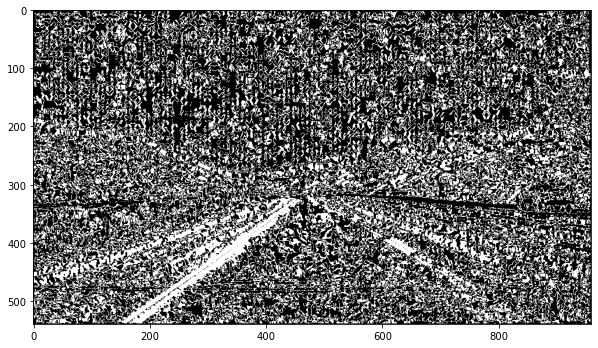

In [11]:
# test dir_thresh
plt.figure(figsize=(10,10))
plt.imshow(dir_thresh(img, kernel_size=9, thresh=(0.7, 1.3)), cmap='gray')
plt.show()

## Combining absolute value, magnitude and direction together

There's still a lot of noise in the resulting image, but now we can combine together the gradient absolute value, its magnitude and its orientation.

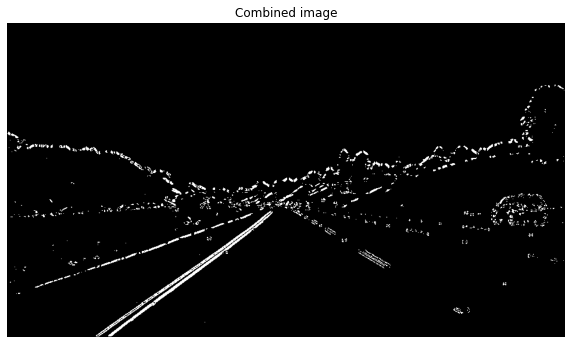

In [12]:
# combine gradient absolute values, magnitude and direction, try to adjust hyperparameters ksize and thresh
sxbinary, sybinary = abs_sobel_thresh(img, kernel_size=3, thresh=(30,100))
mag_grad = mag_thresh(img, kernel_size=9, thresh=(50,100))
dir_grad = dir_thresh(img, kernel_size=9, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_grad)
combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_grad == 1) & (dir_grad == 1))] = 1

plt.figure(figsize=(10,10))
plt.imshow(combined, cmap='gray')
plt.title('Combined image')
plt.axis(False)
plt.show()

# Color Spaces

The techniques discussed so far work well on images with white lines, but their performances drop when the the lines are different colors, or whenever there are different light conditions. For example, let's consider the following image and its R, G and B channels


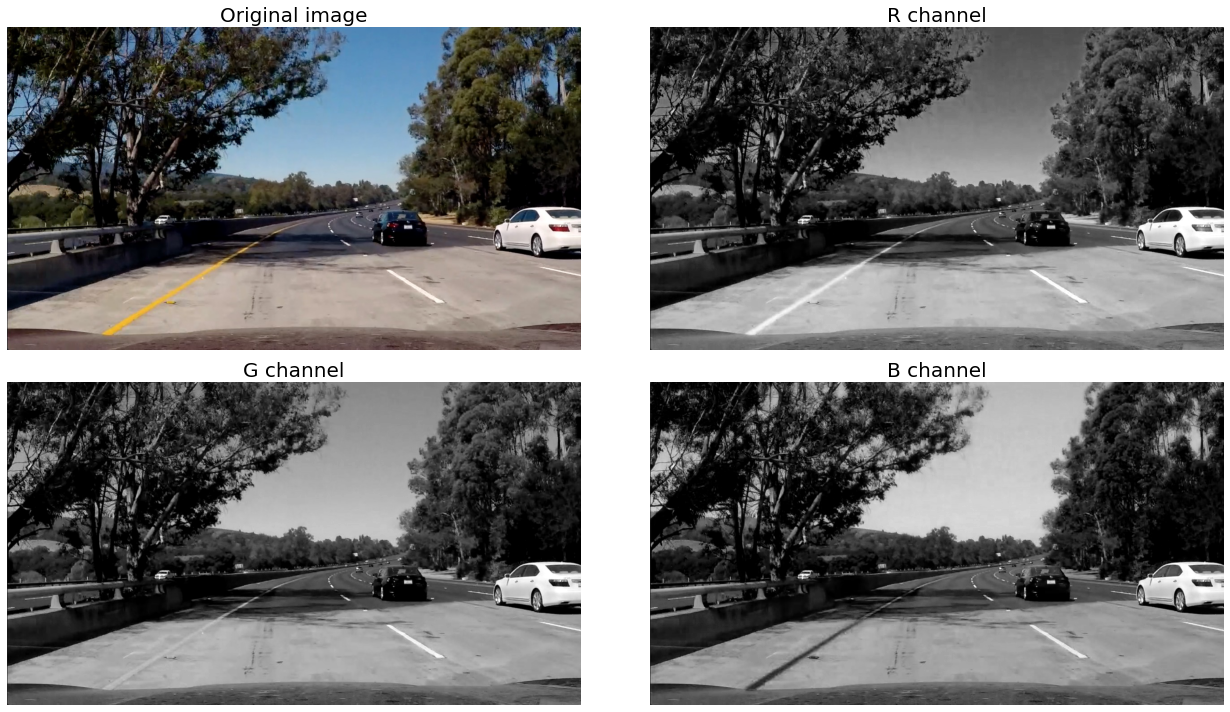

In [13]:
img = mpimg.imread('test_images/shadowCurve.jpg')
fs=20
fig, axs = plt.subplots(2, 2, figsize=(18,10))
fig.tight_layout()
axs[0,0].imshow(img)
axs[0,0].set_title('Original image', fontsize=fs)
axs[0,1].imshow(img[:,:,0], cmap='gray')
axs[0,1].set_title('R channel', fontsize=fs)
axs[1,0].imshow(img[:,:,1], cmap='gray')
axs[1,0].set_title('G channel', fontsize=fs)
axs[1,1].imshow(img[:,:,2], cmap='gray')
axs[1,1].set_title('B channel', fontsize=fs)
for axis in axs:
    axis[0].set_axis_off()
    axis[1].set_axis_off()


As we can see the pixels on the yellow line has high intensity components in the R and G channels, while in the B channels they have low values of in intensity. In order to detect the yellow line, we can focus only the R and G channels, but then a problem arises: the red and green values change under different leves of brightness at the back of the image. As we can see, they get lower under shadow and they don't permit to recognize the lane under extreme brightness.

In order to solve this problem, we can change our color representation system and move from the RGB color space to the HLS (hue, lightness and saturation) color space. The main advantage of this new color representation system is that it contains a specific channel "L" that isolates the lightness component, which varies the most under different lighting conditions. On the opposite, the other two channels (H and S) stay fairly consistent in shadow or excessive brightness.

The image channels in the HLS color space are the following

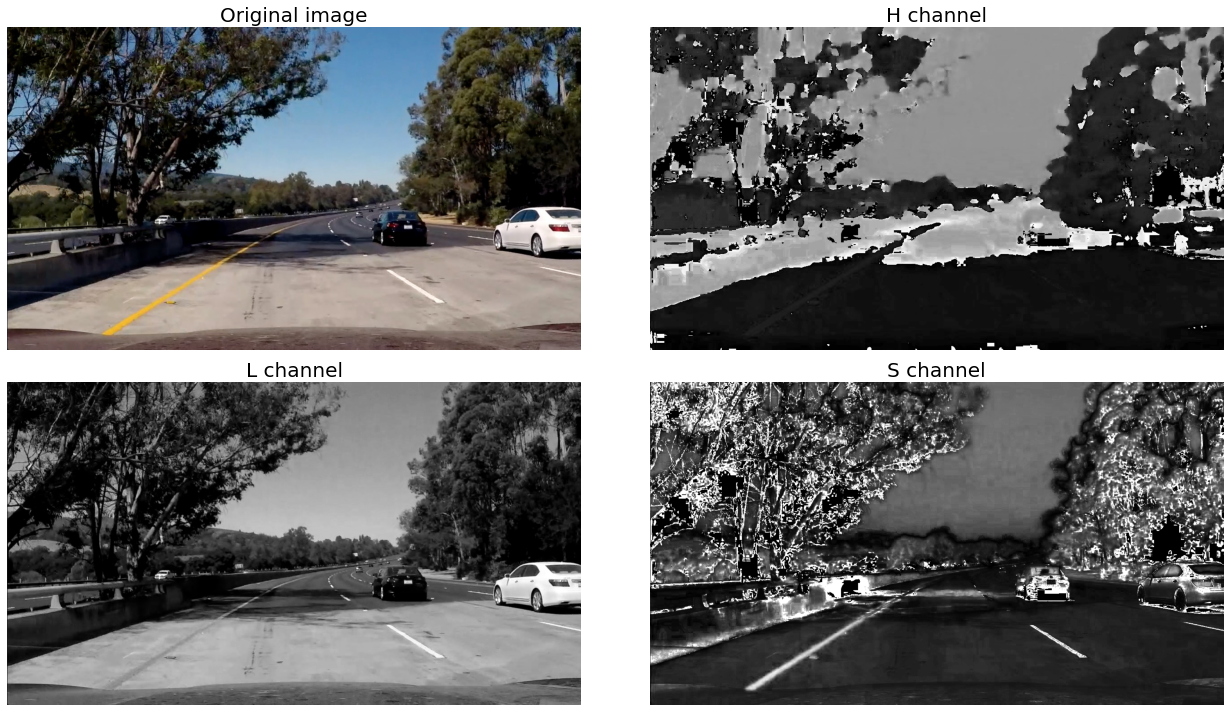

In [14]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
fs = 20
fig, axs = plt.subplots(2, 2, figsize=(18,10))
fig.tight_layout()
axs[0,0].imshow(img)
axs[0,0].set_title('Original image', fontsize=fs)
axs[0,1].imshow(hls[:,:,0], cmap='gray')
axs[0,1].set_title('H channel', fontsize=fs)
axs[1,0].imshow(hls[:,:,1], cmap='gray')
axs[1,0].set_title('L channel', fontsize=fs)
axs[1,1].imshow(hls[:,:,2], cmap='gray')
axs[1,1].set_title('S channel', fontsize=fs)
for axis in axs:
    axis[0].set_axis_off()
    axis[1].set_axis_off()

We can see that the S channel alone is able to highlight lane lines pretty well. Let's construct and compare the binary color thresholds of the R and S channels.

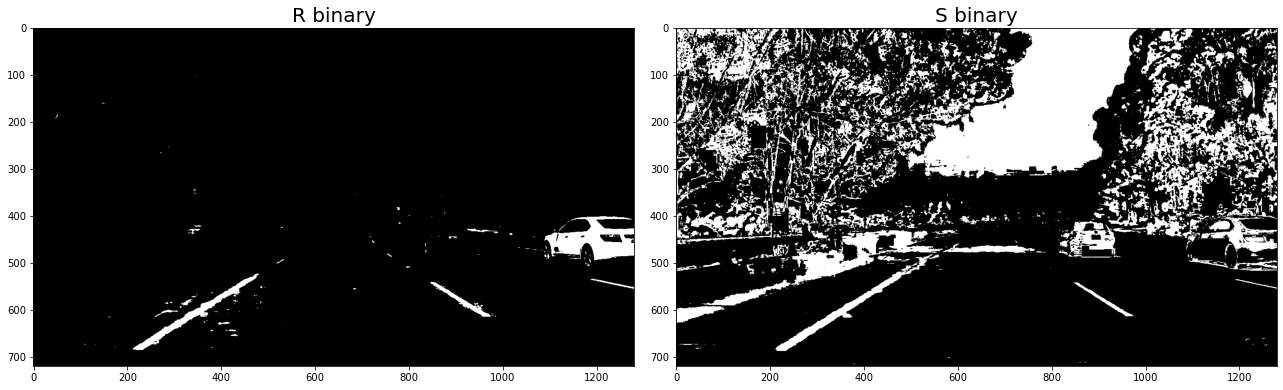

In [15]:
R = img[:,:,0]
thresh = (200, 255)
R_binary = np.zeros_like(R)
R_binary[(R > thresh[0]) & (R <= thresh[1])] = 1

S = hls[:,:,2]
thresh = (90, 255)
S_binary = np.zeros_like(S)
S_binary[(S > thresh[0]) & (S <= thresh[1])] = 1

fig, axs = plt.subplots(1, 2, figsize=(18,15))
fig.tight_layout()
axs[0].imshow(R_binary, cmap='gray')
axs[0].set_title('R binary', fontsize=fs)
axs[1].imshow(S_binary, cmap='gray')
axs[1].set_title('S binary', fontsize=fs)
plt.show()

As we can see the S channel is still doing a fairly robust job of picking up the lines under very different color and contrast conditions, while the other selections from the R channel look messy

# Combining color and gradient thresholding

We are now going to apply color thresholding and gradient thresholding to get the best results out of both worlds.

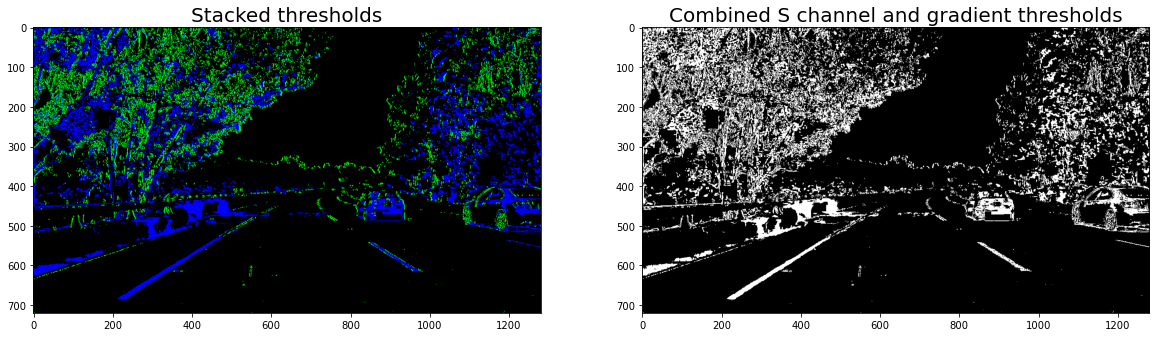

In [16]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 30
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 150
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds', fontsize=fs)
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds', fontsize=fs)
ax2.imshow(combined_binary, cmap='gray')
plt.show()

The final image `color_binary` is a combination of binary thresholding the S channel (HLS) and binary thresholding the result of applying the Sobel operator in the x direction on the original image.
As we can see, ther is a bit of improvement on detecting the right lane line at the back of the image

# Histogram peaks and sliding window

Now that we know how to transform our road image into a bird's-eye view, and we know how to detect edges in more depth, we still have to determine where the lane (curved) lines are in the warped image. There are many ways to do so, but here we will compute the histogram of where the binary activations occur accross the lower part of the image. That will provide us an insight on where the two lines are in the image.

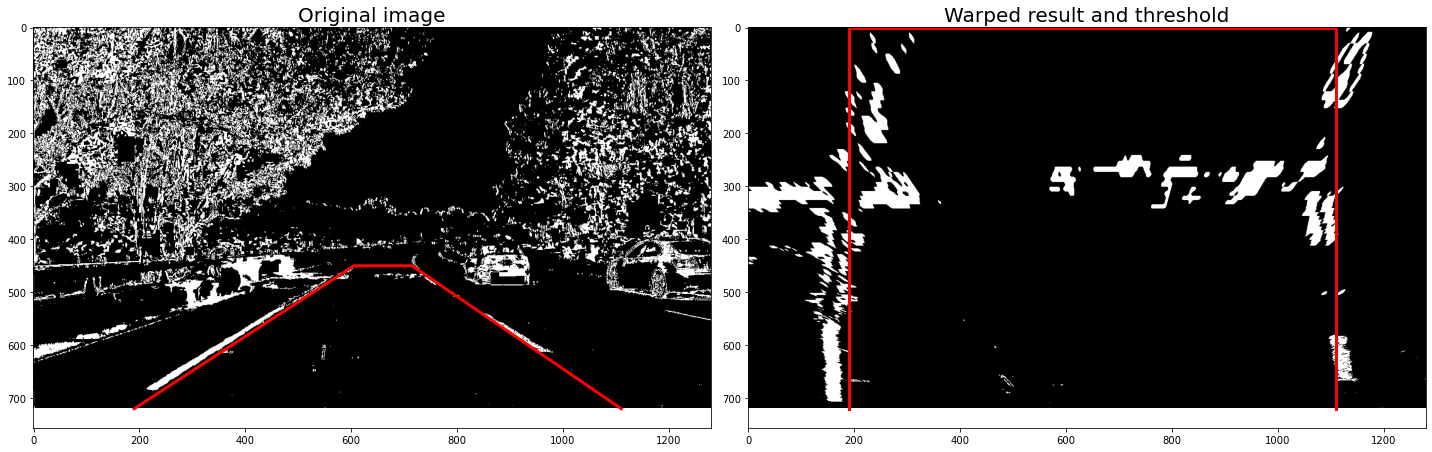

In [17]:
h, w = combined_binary.shape[:2]

# src and dst coordinates for perspective transform
src = np.array([(190, h), (605, 450), (715, 450), (1110, h)], np.float32)
dst = np.array([(190, h), (190, 0), (1110, 0), (1110, h)], np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(combined_binary, M, (w, h), flags=cv2.INTER_LINEAR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,18))
ax1.set_title('Original image', fontsize=fs)
ax1.imshow(combined_binary, cmap='gray')
ax1.plot(src.T[0], src.T[1], 'r-', linewidth=3)

ax2.imshow(warped, cmap='gray')
ax2.plot(dst.T[0], dst.T[1], 'r-', linewidth=3)
ax2.set_title('Warped result and threshold', fontsize=fs)
plt.tight_layout()
plt.show()

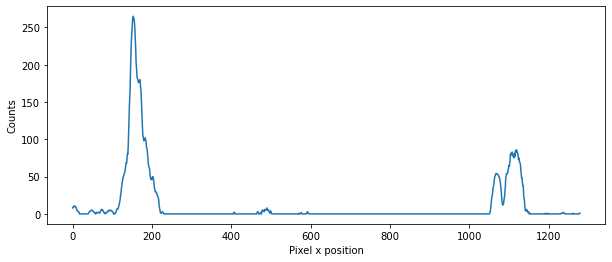

In [18]:
def hist(img):
    """Compute histogram by summing bottom-half pixels in each column"""
    bottom_half = img[img.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

# plot histogram
plt.figure(figsize=(10,4))
plt.plot(hist(warped))
plt.xlabel('Pixel x position')
plt.ylabel('Counts')
plt.show()

Peaks in the histogram of the lower half of the thresholded warped image indicate a concentration of white pixels, meaning that a line is likely to be present at that *x* position. That information can be used as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

## Sliding window

We can use the two highest peaks in the histogram as a starting point fordetermining where the lane lines are, and then use sliding windows moving upward in the image, further along the road, to determine where the lines go. We proceed as follows:
1. Split the histogram into two sides, one for each line.
2. Set up hyperparameters related to the sliding window.
3. Iterate through the windows, re-centering the given window sliding left or right if it finds the mean position of the activated pixels within the window to have shifted more than a certain, specified, value.
4. At each iteration, append to lists `left_lane_inds` and `right_lane_inds` the activated pixels that fall into the window.
5. After we have found all the pixels belonging to each line through the sliding window, we fit a polynomial to the line.

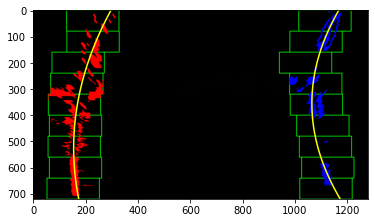

In [26]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # number of sliding windows
    nwindows = 9
    # width of the windows +/- margin
    margin = 100
    # minimum number of pixels found to recenter window
    minpix = 50

    # height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) 
                          & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)
                         ).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) 
                          & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)
                         ).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial(warped)

plt.imshow(out_img)
plt.show()

## Finding the lines in a new frame

Using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lines don't necessarily move a lot from frame to frame. In the next frame of video we don't need to do a blind search again, but instead we can just search in a margin around the previous line position: once we know where the lines are in one frame of video, we can do a highly targeted search for them in the next frame.

All we need to do now is grab only those pixels in the new frame with x-value that are +/- our `margin` from the polynomial lines detected in the frame before. Then we will just do a new polynomial fit on these new pixels. 


In [ ]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


#QUESTA FUNZIONE DEVE ESSERE INVOCATA SU OGNI NUOVO FRAME, PERO' BISOGNA PRIMA IMPLEMENTARE UNA FUNZIONE CHE CALCOLI IL BINARY_WARPED DEL NUOVO FRAME
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result